In [ ]:
#citation https://github.com/madsendennis/notebooks/blob/master/volume_segmentation_with_unet/01_Volume-Segmentation-with-UNET_Pre-processing.ipynb

#Segmentation Using UNet

In [ ]:
#USE THIS
from tensorflow.keras.models import *
import scipy.misc as sc
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT =256 #256
IMAGE_WIDTH =176 #176
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = '/content/gdrive/MyDrive/FourthBrain Project/Data/Seg2/'
data_dir_train = os.path.join(data_dir, 'train')
# The images should be stored under: "data/slices/train/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "data/slices/train/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'msk4')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'msk4')

NUM_TRAIN = 2024
NUM_TEST = 512

NUM_OF_EPOCHS = 100

In [ ]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [ ]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 2048 images belonging to 1 classes.
Found 2048 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 512 images belonging to 1 classes.


In [ ]:
data_dir_test_image

'/content/gdrive/MyDrive/FourthBrain Project/Data/Seg2/test/img'

In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

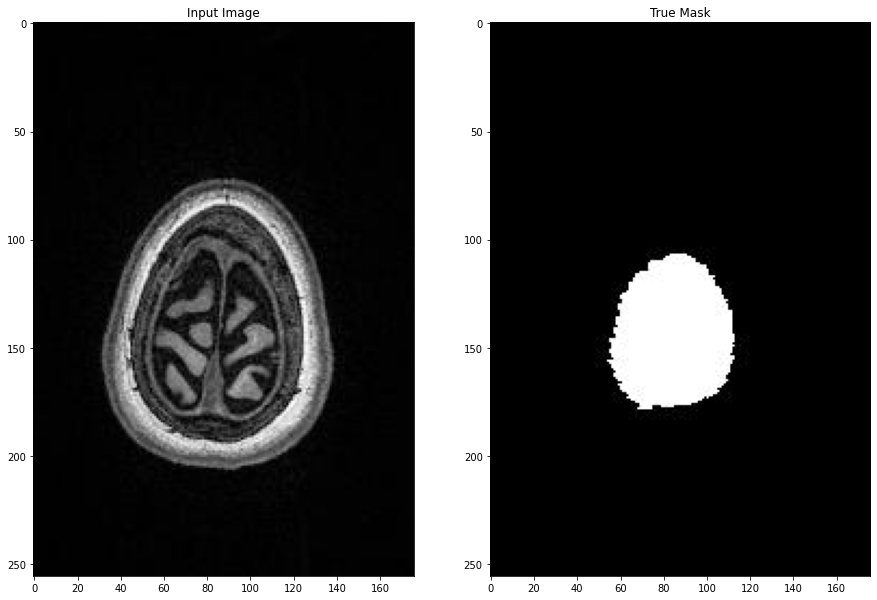

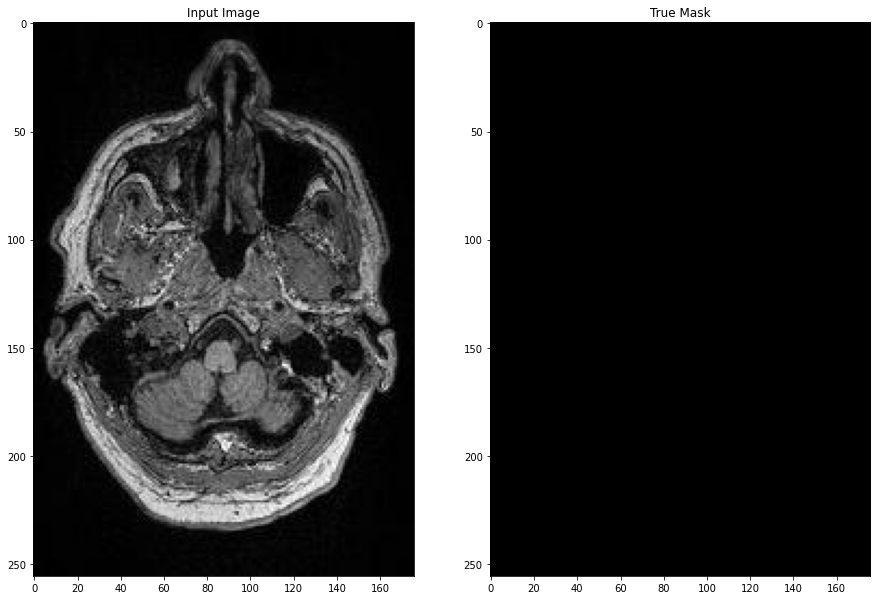

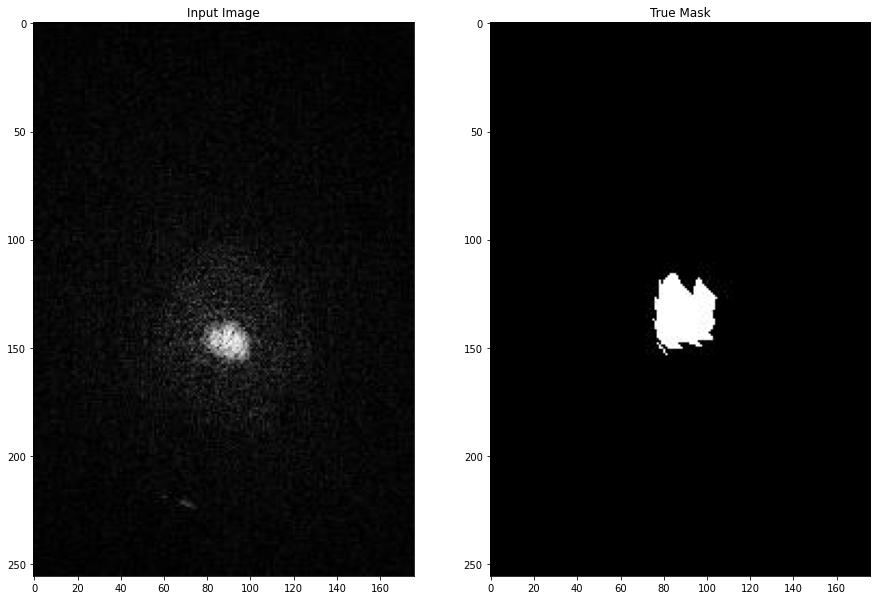

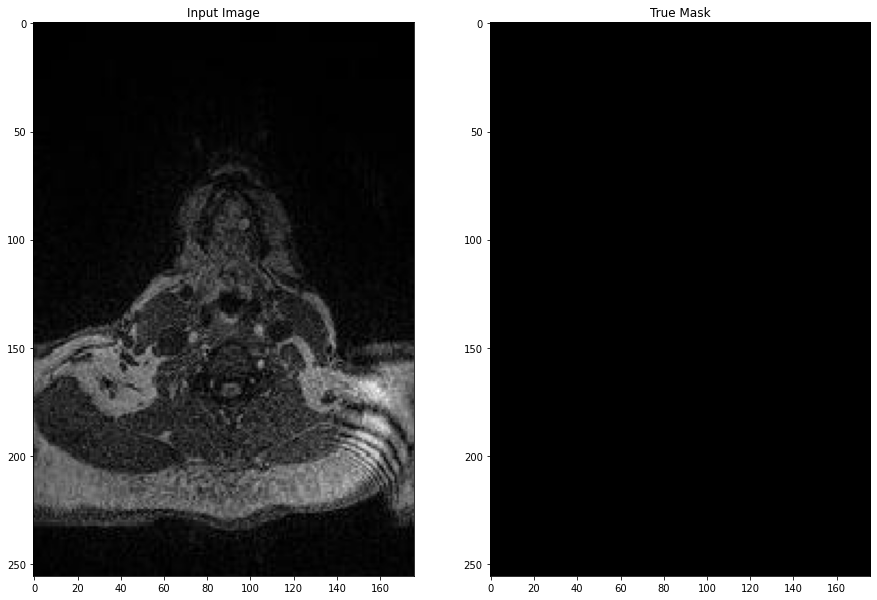

In [ ]:
show_dataset(train_generator, 4)

In [ ]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [ ]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

In [ ]:
model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 176, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 176, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 176, 32) 9248        conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 88, 32)  0           conv2d_16[0][0]                  
________________________________________________________________________________________

In [ ]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
63/63 [==============================] - 763s 12s/step - loss: 0.2848 - accuracy: 0.8983 - precision: 0.0030 - recall: 7.8150e-06 - val_loss: 0.1679 - val_accuracy: 0.8944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
63/63 [==============================] - 14s 228ms/step - loss: 0.1564 - accuracy: 0.8984 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1222 - val_accuracy: 0.8954 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
63/63 [==============================] - 14s 228ms/step - loss: 0.1293 - accuracy: 0.9301 - precision: 0.7881 - recall: 0.4654 - val_loss: 0.1059 - val_accuracy: 0.9510 - val_precision: 0.8729 - val_recall: 0.6973
Epoch 4/100
63/63 [==============================] - 14s 229ms/step - loss: 0.1011 - accuracy: 0.9511 - precision: 0.7953 - recall: 0.7708 - val_loss: 0.0768 - val_accuracy: 0.9594 - val_precision: 0.9464 - val_recall: 0.6565
Epoch 5/100
63/63 [==============================] - 14s 228ms/step -

In [ ]:
#48/48 [==============================] - 8s 158ms/step - loss: 0.0104 - accuracy: 0.9880 - precision: 0.9721 - recall: 0.8738 - val_loss: 0.0726 - val_accuracy: 0.9754 - val_precision: 0.8170 - val_recall: 0.6297

#48/48 [==============================] - 7s 152ms/step - loss: 0.0054 - accuracy: 0.9832 - precision: 0.9964 - recall: 0.9156 - val_loss: 0.0758 - val_accuracy: 0.9718 - val_precision: 0.9607 - val_recall: 0.8105

#63/63 [==============================] - 14s 228ms/step - loss: 0.0052 - accuracy: 0.9836 - precision: 0.9963 - recall: 0.9150 - val_loss: 0.0695 - val_accuracy: 0.9718 - val_precision: 0.9645 - val_recall: 0.8139

In [ ]:
model.save(f'UNET-BrainSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_6.h5')

In [ ]:
model2 = load_model('UNET-BrainSegmentation_256_176_6.h5')

In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

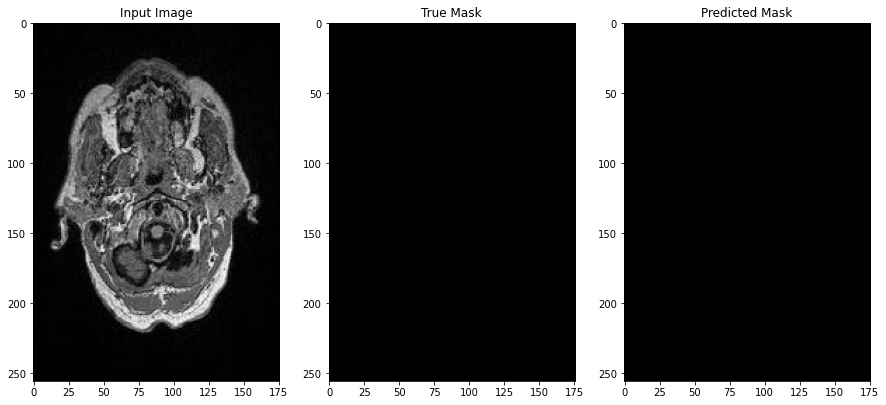

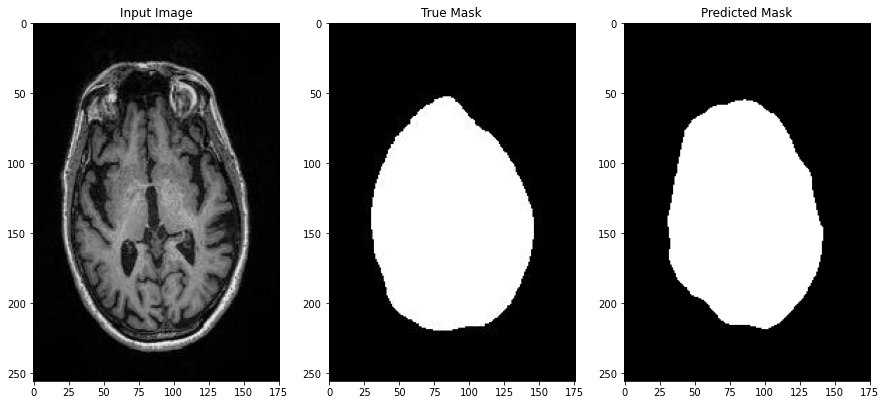

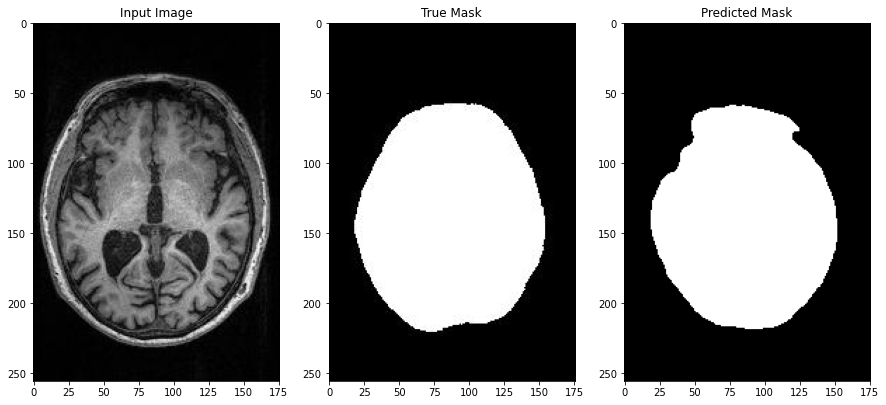

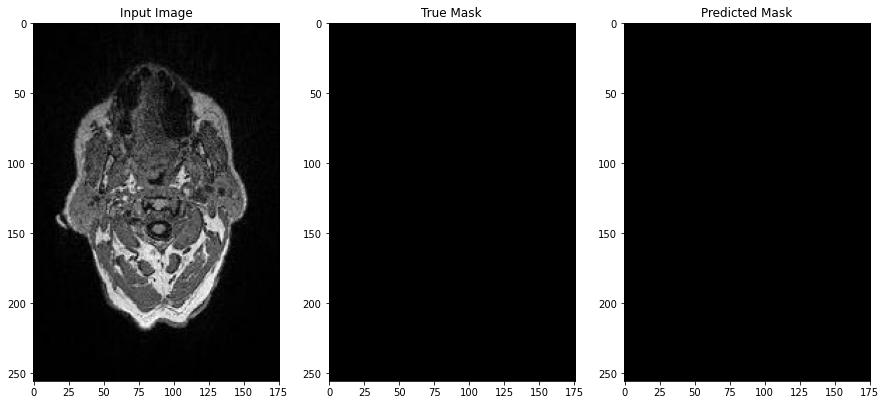

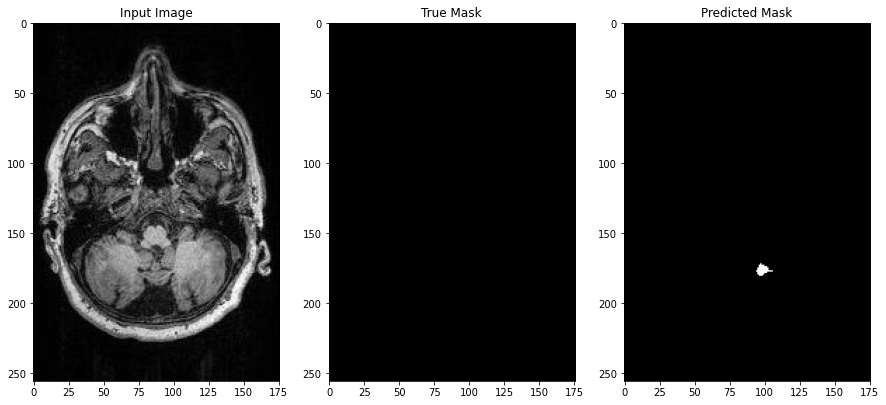

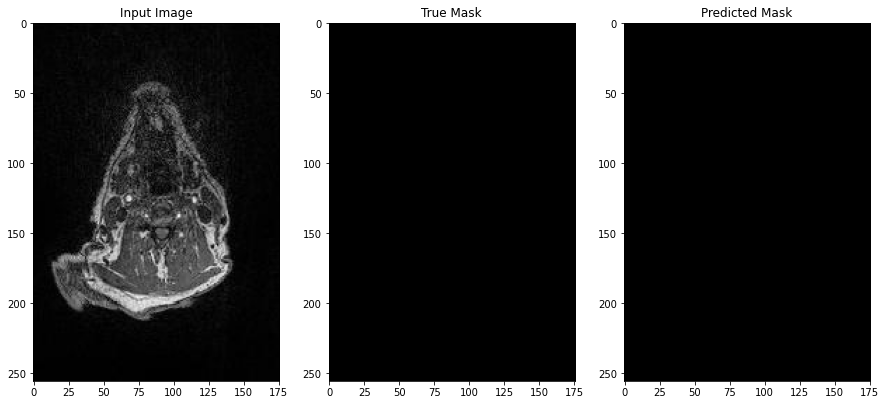

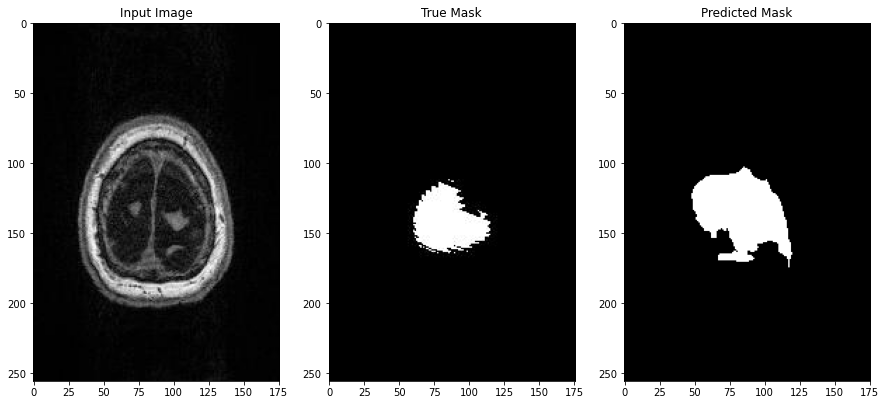

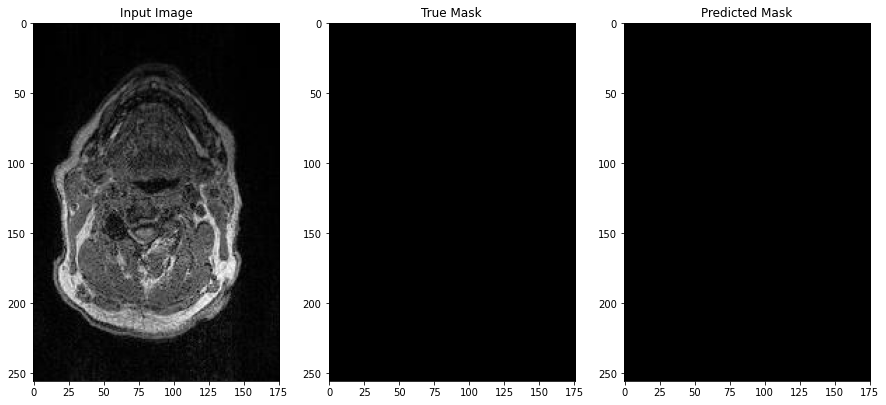

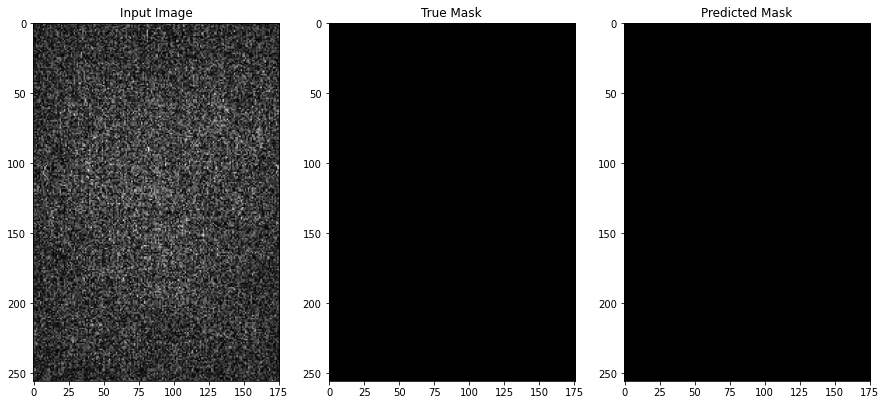

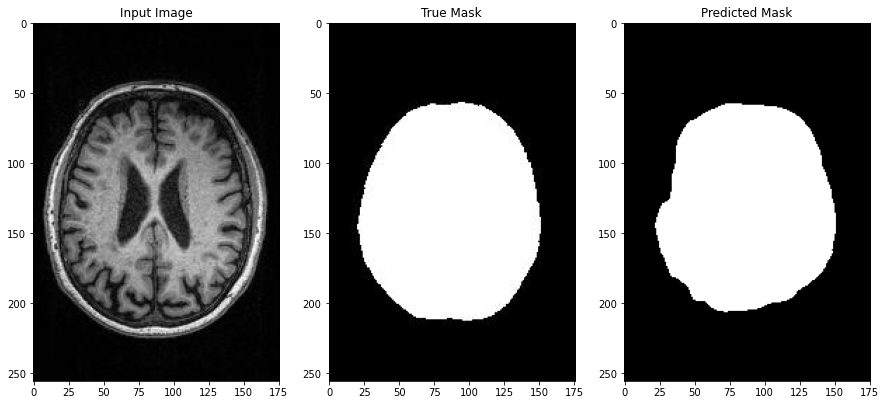

In [ ]:
show_prediction(test_generator, 10)

In [ ]:
!pip install niwidgets

     |████████████████████████████████| 12.5MB 10.8MB/s 
     |████████████████████████████████| 3.3MB 46.2MB/s 
     |████████████████████████████████| 2.9MB 46.7MB/s 
     |████████████████████████████████| 5.4MB 52.8MB/s 
     |████████████████████████████████| 2.4MB 58.0MB/s 
     |████████████████████████████████| 266kB 50.8MB/s 
     |████████████████████████████████| 3.4MB 56.6MB/s 
     |████████████████████████████████| 276kB 62.0MB/s 
ERROR: nibabel 2.5.2 has requirement numpy<1.17dev,>=1.8, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


##Part 3

#Predicting Volume

In [ ]:
from tensorflow.keras.models import load_model
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
imagePathInput='/content/'
imgPath = os.path.join(imagePathInput, '680.nii.gz')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(0.0, 1778.0, (176, 240, 256), numpy.ndarray)

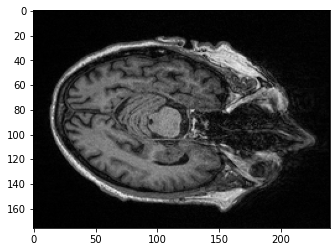

In [ ]:
# Show image slice
imgSlice = img[:,:,110]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [ ]:
# Define constants
HOUNSFIELD_MIN = 0
HOUNSFIELD_MAX = 500
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

#SLICE_X = True
#SLICE_Y = True
#SLICE_Z = False

SLICE_X = False
SLICE_Y = False
SLICE_Z = True

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 176
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [ ]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [ ]:
def normalizeImage(img):
    return (img)/255

In [ ]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [ ]:
def scaleImg2(img, height, width):
    return img

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
targetName = '600'
#targetImagePath = f'data/volumes/img/{targetName}.nii'
#targetMaskPath  = f'data/volumes/mask/{targetName}.nii'
targetImagePath = f'{targetName}.nii.gz'
targetMaskPath  = f'{targetName}.nii'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

#imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgTarget = normalizeImage(imgTargetNii.get_fdata())
#imgTarget = imgTargetNii.get_fdata()
imgMask = normalizeImage(imgMaskNii.get_fdata())

In [ ]:
model2 = load_model('UNET-BrainSegmentation_256_176_6.h5')

In [ ]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model2.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model2.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model2.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [ ]:
predImg = predictVolume(imgTarget)

In [ ]:
pip freeze > requirements.txt

In [ ]:
!python --version

Python 3.7.10


In [ ]:
segImg=predImg*imgTarget

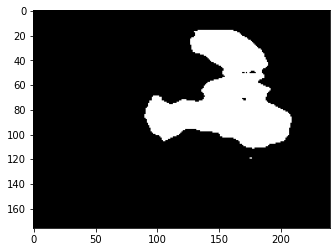

In [ ]:
plt.imshow(predImg[:, :, 60], cmap="gray")
plt.show()

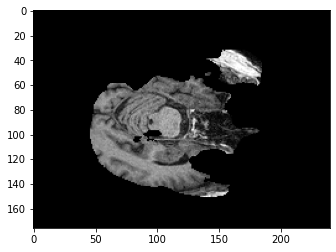

In [ ]:
plt.imshow(segImg[:, :, 110], cmap="gray")
plt.show()

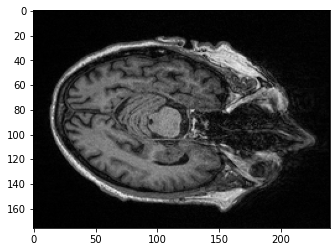

In [ ]:
plt.imshow(imgTarget[:, :, 110], cmap="gray")
plt.show()

In [ ]:
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=87, continuous_update=False, description='x', max=175), IntSlider(value=…

In [ ]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=87, continuous_update=False, description='x', max=175), IntSlider(value=…

In [ ]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(imgMask*imgTarget))
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=87, continuous_update=False, description='x', max=175), IntSlider(value=…

#Classification

In [ ]:
import matplotlib.pyplot as plt
#-################################-#
import nibabel as nib
#-################################-#
import numpy as np
#-################################-#
import os
from os import listdir
from os.path import isfile, join
#-################################-#
import pandas as pd
#-################################-#
import random
#-################################-#
from scipy import ndimage
#-################################-#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shutil

In [ ]:
cwd = "/content/gdrive/MyDrive/FourthBrain Project/Data"

In [ ]:
labels = pd.read_csv(join(cwd, "MR H Lables.csv"))
vertical = pd.read_csv(join(cwd, "Vertical.csv"))
result = pd.merge(labels, vertical, how="outer", on=["MR"])

In [ ]:
#-####################################################################-#
#                           READING A SUBSET OF THE NIFTII FILES' PATHS                           #
#-####################################################################-#
niftii_files = [
    f for f in listdir(join(cwd, "NIFTI Files")) if isfile(join(cwd, "NIFTI Files", f))]; niftii_files.sort()

#-####################################################################-#
#     IMPORTING THE CDR LABELS & FILTERING FOR THE SELECTED SUBSET      #
#-####################################################################-#
labels = pd.read_csv(join(cwd, "MR H Lables.csv"))

labels_subset = labels.loc[labels["MR"].isin(niftii_files), :] \
.sort_values(by="MR").reset_index(inplace=False)

normal_subjects = labels_subset.loc[labels_subset["CDR"] == 0, :].sort_values(by="MR") \
.reset_index(inplace=False)
normal_paths = [join(cwd, "NIFTI Files", f) for f in normal_subjects["MR"]]

dimentia_all = labels_subset.loc[labels_subset["CDR"] > 0, :].sort_values(by="MR") \
.reset_index(inplace=False)
dimentia_paths = [join(cwd, "NIFTI Files", f) for f in dimentia_all["MR"]]

ad_subjects = labels_subset.loc[labels_subset["CDR"] > 0.5, :].sort_values(by="MR") \
.reset_index(inplace=False)
ad_paths = [join(cwd, "NIFTI Files", f) for f in ad_subjects["MR"]]

#-####################################################################-#
# TEST IF THE LABELS MATCH THE FILES IN NUNBER, I.E., COUNT
assert (
    (len(niftii_files) == len(labels_subset)) &
    (len(normal_subjects) == len(normal_paths)) &
    (len(dimentia_all) == len(dimentia_paths)) &
    (len(ad_subjects) == len(ad_paths)) ), "Count of files and labels don't match."

#-####################################################################-#
# CHECKING FOR THE PRESENCE OF SUBJECTS WITH DIMENTIA
print(
    "Subjects with CDR = 0: " + str(len(normal_subjects)) +
    "\nSubjects with CDR > 0: " + str(len(dimentia_all)) +
    "\nSubjects with CDR = 1: " + str(len(ad_subjects)))

Subjects with CDR = 0: 2177
Subjects with CDR > 0: 596
Subjects with CDR = 1: 173


In [ ]:
List=[]
for i in reversed(range(len(dimentia_paths))):
  if dimentia_paths[i][65:73] == dimentia_paths[i-1][65:73]:
    List.append(i)
for i in reversed(range(len(dimentia_paths))):
  for j in range(len(List)):
    if List[j]==i:
      dimentia_paths.remove(dimentia_paths[i])
List=[]
for i in reversed(range(len(normal_paths))):
  if normal_paths[i][65:73] == normal_paths[i-1][65:73]:
    List.append(i)
for i in reversed(range(len(normal_paths))):
  for j in range(len(List)):
    if List[j]==i:
      normal_paths.remove(normal_paths[i])
List=[]
for i in reversed(range(len(ad_paths))):
  if ad_paths[i][65:73] == ad_paths[i-1][65:73]:
    List.append(i)
for i in reversed(range(len(ad_paths))):
  for j in range(len(List)):
    if List[j]==i:
      ad_paths.remove(ad_paths[i])

#for range(len(dimentia_paths2),1):
#  print(i)

In [ ]:
print(
    "Subjects with CDR = 0: " + str(len(normal_paths)) +
    "\nSubjects with CDR > 0: " + str(len(dimentia_paths)) +
    "\nSubjects with CDR = 1: " + str(len(ad_paths)))

Subjects with CDR = 0: 778
Subjects with CDR > 0: 348
Subjects with CDR = 1: 116


In [ ]:
normal_paths2 = normal_paths[0:75]
#dimentia_paths2 = dimentia_paths[519:569]
ad_paths2 = ad_paths[25:100]

In [ ]:
len(ad_paths2)

75

In [ ]:
#-####################################################################-#
def process_scan(filepath):
    """
    Read, Normalize, and Resize Image Volumes
    - Normalizing a target image by subtracting the mean of the whole brain and dividing
    by its standard deviation, i.e., Z-score
    Args:
        filepath (string): the target MR brain image raw data
    Returns:
        norm_value (numpy.ndarray): Normalized image raw data
        norm_img (nibabel.nifti1.Nifti1Image): img with WM mean at norm_value
    """
    
    img = nib.load(filepath)
    img_data = img.get_fdata()
    img_data2 = predictVolume(img_data)
    img_data = img_data*img_data2
    img_data = img_data[:, :, 0:249]#85:165]

    # NORMALIZE
    mask_data = img_data > img_data.mean()
    logical_mask = mask_data > 0.  # forcing the mask to be logical type
    mean = img_data[logical_mask].mean()
    std = img_data[logical_mask].std()
    norm_value = (img_data - mean) / std
    img = norm_value.astype("float32")
    
    # RESIZE - Setting the desired depth
    desired_depth =250 #80 #80 #64
    desired_width =170 #160 #80 #128
    desired_height =250 #160 #80 #128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [ ]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        # volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < -3] = -3
        volume[volume > 3] = 3
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [ ]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
train_dataset=[]

In [ ]:
#-####################################################################-#
# PROCESS THE BRAIN MRI'S, i.e., READ AND NORMALIZE THEM.
normal_mris = np.array([process_scan(path) for path in normal_paths2]) #90 minutes
dimentia_mris = np.array([process_scan(path) for path in ad_paths2]) #30 minutes

#-################################-#
# FOR THE AD MRI'S ASSIGN 1 AND FOR THE NORMAL ONES ASSIGN 0.
normal_labels = np.array([0 for _ in range(len(normal_mris))])
dimentia_labels = np.array([1 for _ in range(len(dimentia_mris))])

#-################################-#
# Split Data in ~80:20 for
#-00. TRAINING
x_train = np.concatenate((normal_mris[:60], dimentia_mris[:60]), axis=0)
y_train = np.concatenate((normal_labels[:60], dimentia_labels[:60]), axis=0)
#x_train = np.concatenate((normal_mris[:110], dimentia_mris[:43]), axis=0)
#y_train = np.concatenate((normal_labels[:110], dimentia_labels[:43]), axis=0)

#-01. VALIDATION
x_val = np.concatenate((normal_mris[60:], dimentia_mris[60:]), axis=0)
y_val = np.concatenate((normal_labels[60:], dimentia_labels[60:]), axis=0)
#x_val = np.concatenate((normal_mris[110:], dimentia_mris[43:]), axis=0)
#y_val = np.concatenate((normal_labels[110:], dimentia_labels[43:]), axis=0)

In [ ]:
#-####################################################################-#
# DATA LOADERS
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#-################################-#
# BATCH SIZE
batch_size = 2
#-################################-#
# AUGMENTING SCANS DURING TRAINING
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2))
#-################################-#
# RESCALING FOR VALIDATION SET
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2))

Dimension of the MRI is: (170, 250, 250, 1)


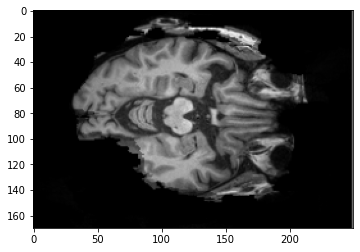

In [ ]:
#-####################################################################-#
# VISUALIZE PRE-PROCESSED DATA.0
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 110]), cmap="gray")
plt.show()

In [ ]:
# Shayan edit for full NIFTII Sizes
#-####################################################################-#
# CONFIGUING, I.E., DEFINING, THE MODEL
def get_model(width=170, height=250, depth=250):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    #x = layers.Dropout(0.9)(inputs)
    
    x = layers.Conv3D(filters=8, kernel_size=5, padding='same',activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=16, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)

    x = layers.Dense(units=32, activation="relu")(x)

    #x = layers.Dropout(0.9)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs, name="3dcnn-shahamat-shayan-170-250-250_v13")
    return model
#-################################-#
# BUILIDING THE MODEL
model = get_model(width=170, height=250, depth=250)
model.summary()

Model: "3dcnn-shahamat-shayan-170-250-250_v13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 170, 250, 250, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 170, 250, 250, 8)  1008      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 85, 125, 125, 8)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, 85, 125, 125, 8)   32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 85, 125, 125, 16)  3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 42, 62, 62, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch 

In [ ]:
#-####################################################################-#
# COMPILING THE MODEL
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate
    , decay_steps=100000
    , decay_rate=0.96
    , staircase=True)

model.compile(
      loss="binary_crossentropy"
    , optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    , metrics=["acc","Precision","Recall"],)

# CALLBACKS
checkpoint_cb = keras.callbacks.ModelCheckpoint(
      "3dcnn-shahamat-shayan-170-250-250_v13.h5"
    , save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
      monitor="val_acc"
    , patience=15)

In [ ]:
#-####################################################################-#
# TRAIN THE MODEL, DOING VALIDATION AT THE END OF EACH EPOCH
epochs = 15
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    )

Epoch 1/15
60/60 - 38s - loss: 8.1137 - acc: 0.5833 - precision: 0.5781 - recall: 0.6167 - val_loss: 2.6973 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
60/60 - 32s - loss: 2.2333 - acc: 0.7250 - precision: 0.7647 - recall: 0.6500 - val_loss: 0.7413 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
60/60 - 31s - loss: 0.3530 - acc: 0.7833 - precision: 0.7297 - recall: 0.9000 - val_loss: 0.5503 - val_acc: 0.6333 - val_precision: 0.8333 - val_recall: 0.3333
Epoch 4/15
60/60 - 31s - loss: 0.2242 - acc: 0.9000 - precision: 0.9286 - recall: 0.8667 - val_loss: 0.8127 - val_acc: 0.8667 - val_precision: 0.7895 - val_recall: 1.0000
Epoch 5/15
60/60 - 31s - loss: 0.1848 - acc: 0.9333 - precision: 0.9483 - recall: 0.9167 - val_loss: 1.2616 - val_acc: 0.5667 - val_precision: 0.5357 - val_recall: 1.0000
Epoch 6/15
60/60 - 31s - loss: 0.0447 - acc: 0.9833 - precision: 0.9833 - recall: 0.9833 - val_loss: 0.4693 - val_acc: 0.7333 - v

In [ ]:
#40/40 - 10s - loss: 0.5137 - acc: 0.7250 - val_loss: 8.1912 - val_acc: 0.5000

#No Drop Out:
#60/60 - 33s - loss: 2.8544e-05 - acc: 1.0000 - val_loss: 2.1096 - val_acc: 0.7333

#acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.9069 - val_acc: 0.8333 - val_precision: 0.7500 - val_recall: 1.0000



In [ ]:
#-####################################################################-#
def process_scan2(img_data):
    """
    Read, Normalize, and Resize Image Volumes
    - Normalizing a target image by subtracting the mean of the whole brain and dividing
    by its standard deviation, i.e., Z-score
    Args:
        filepath (string): the target MR brain image raw data
    Returns:
        norm_value (numpy.ndarray): Normalized image raw data
        norm_img (nibabel.nifti1.Nifti1Image): img with WM mean at norm_value
    """
    
    #img = nib.load(filepath)
    #img_data = img.get_fdata()
    #img_data2 = predictVolume(img_data)
    #img_data = img_data*img_data2
    img_data = img_data[:, :, 0:249]#85:165]

    # NORMALIZE
    mask_data = img_data > img_data.mean()
    logical_mask = mask_data > 0.  # forcing the mask to be logical type
    mean = img_data[logical_mask].mean()
    std = img_data[logical_mask].std()
    norm_value = (img_data - mean) / std
    img = norm_value.astype("float32")
    
    # RESIZE - Setting the desired depth
    desired_depth =250 #80 #80 #64
    desired_width =170 #160 #80 #128
    desired_height =250 #160 #80 #128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [ ]:
segImg2.shape

(170, 250, 250)

In [ ]:
x_val[0].shape

(170, 250, 250)

In [ ]:
#segImg.shape

segImg2=process_scan2(segImg)

In [ ]:
model.predict(np.expand_dims(segImg2,axis=0))

array([[0.9949238]], dtype=float32)

In [ ]:
import shutil

original = r'3dcnn-shahamat-shayan-170-250-250_v13.h5'
target = r'gdrive/MyDrive/FourthBrain Project/Final Code/3dcnn-shahamat-shayan-170-250-250_v13.h5'

shutil.copyfile(target,original)

'3dcnn-shahamat-shayan-170-250-250_v13.h5'

#Testing

In [ ]:
#USE THIS
from tensorflow.keras.models import *
import scipy.misc as sc
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras


import matplotlib.pyplot as plt
#-################################-#
import nibabel as nib
#-################################-#
import numpy as np
#-################################-#
import os
from os import listdir
from os.path import isfile, join
#-################################-#
import pandas as pd
#-################################-#
import random
#-################################-#
from scipy import ndimage
#-################################-#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shutil

In [ ]:
UNet_model = load_model('gdrive/MyDrive/FourthBrain Project/Final Code/use this/UNET-BrainSegmentation_256_176_6.h5')
CNN_model = load_model('gdrive/MyDrive/FourthBrain Project/Final Code/use this/3dcnn-shahamat-shayan-170-250-250_v13.h5')

In [ ]:
SLICE_X = False
SLICE_Y = False
SLICE_Z = True

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 176
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [ ]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [ ]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = UNet_model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = UNet_model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = UNet_model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
            
    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [ ]:
#-####################################################################-#
def process_scan2(filepath):
    """
    Read, Normalize, and Resize Image Volumes
    - Normalizing a target image by subtracting the mean of the whole brain and dividing
    by its standard deviation, i.e., Z-score
    Args:
        filepath (string): the target MR brain image raw data
    Returns:
        norm_value (numpy.ndarray): Normalized image raw data
        norm_img (nibabel.nifti1.Nifti1Image): img with WM mean at norm_value
    """
    
    img = nib.load(filepath)
    img_data = img.get_fdata()
    img_data2 = predictVolume(img_data)
    img_data = img_data*img_data2
    img_data = img_data[:, :, 0:249]#85:165]

    # NORMALIZE
    mask_data = img_data > img_data.mean()
    logical_mask = mask_data > 0.  # forcing the mask to be logical type
    mean = img_data[logical_mask].mean()
    std = img_data[logical_mask].std()
    norm_value = (img_data - mean) / std
    img = norm_value.astype("float32")
    
    # RESIZE - Setting the desired depth
    desired_depth =250 #80 #80 #64
    desired_width =170 #160 #80 #128
    desired_height =250 #160 #80 #128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [ ]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [ ]:
def normalizeImage(img):
    return (img)/255

In [ ]:
def scaleImg2(img, height, width):
    return img

In [ ]:
cwd = "/content/gdrive/MyDrive/FourthBrain Project/Data"

In [ ]:
labels = pd.read_csv(join(cwd, "MR H Lables.csv"))
vertical = pd.read_csv(join(cwd, "Vertical.csv"))
result = pd.merge(labels, vertical, how="outer", on=["MR"])

In [ ]:
#-####################################################################-#
#                           READING A SUBSET OF THE NIFTII FILES' PATHS                           #
#-####################################################################-#
niftii_files = [
    f for f in listdir(join(cwd, "NIFTI Files")) if isfile(join(cwd, "NIFTI Files", f))]; niftii_files.sort()

#-####################################################################-#
#     IMPORTING THE CDR LABELS & FILTERING FOR THE SELECTED SUBSET      #
#-####################################################################-#
labels = pd.read_csv(join(cwd, "MR H Lables.csv"))

labels_subset = labels.loc[labels["MR"].isin(niftii_files), :] \
.sort_values(by="MR").reset_index(inplace=False)

normal_subjects = labels_subset.loc[labels_subset["CDR"] == 0, :].sort_values(by="MR") \
.reset_index(inplace=False)
normal_paths = [join(cwd, "NIFTI Files", f) for f in normal_subjects["MR"]]

dimentia_all = labels_subset.loc[labels_subset["CDR"] == 0.5, :].sort_values(by="MR") \
.reset_index(inplace=False)
dimentia_paths = [join(cwd, "NIFTI Files", f) for f in dimentia_all["MR"]]

ad_subjects = labels_subset.loc[labels_subset["CDR"] > 0.5, :].sort_values(by="MR") \
.reset_index(inplace=False)
ad_paths = [join(cwd, "NIFTI Files", f) for f in ad_subjects["MR"]]

#-####################################################################-#
# TEST IF THE LABELS MATCH THE FILES IN NUNBER, I.E., COUNT
assert (
    (len(niftii_files) == len(labels_subset)) &
    (len(normal_subjects) == len(normal_paths)) &
    (len(dimentia_all) == len(dimentia_paths)) &
    (len(ad_subjects) == len(ad_paths)) ), "Count of files and labels don't match."

#-####################################################################-#
# CHECKING FOR THE PRESENCE OF SUBJECTS WITH DIMENTIA
print(
    "Subjects with CDR = 0: " + str(len(normal_subjects)) +
    "\nSubjects with CDR > 0: " + str(len(dimentia_all)) +
    "\nSubjects with CDR = 1: " + str(len(ad_subjects)))

Subjects with CDR = 0: 2177
Subjects with CDR > 0: 423
Subjects with CDR = 1: 173


In [ ]:
List=[]
for i in reversed(range(len(dimentia_paths))):
  if dimentia_paths[i][65:73] == dimentia_paths[i-1][65:73]:
    List.append(i)
for i in reversed(range(len(dimentia_paths))):
  for j in range(len(List)):
    if List[j]==i:
      dimentia_paths.remove(dimentia_paths[i])
List=[]
for i in reversed(range(len(normal_paths))):
  if normal_paths[i][65:73] == normal_paths[i-1][65:73]:
    List.append(i)
for i in reversed(range(len(normal_paths))):
  for j in range(len(List)):
    if List[j]==i:
      normal_paths.remove(normal_paths[i])
List=[]
for i in reversed(range(len(ad_paths))):
  if ad_paths[i][65:73] == ad_paths[i-1][65:73]:
    List.append(i)
for i in reversed(range(len(ad_paths))):
  for j in range(len(List)):
    if List[j]==i:
      ad_paths.remove(ad_paths[i])

#for range(len(dimentia_paths2),1):
#  print(i)

In [ ]:
print(
    "Subjects with CDR = 0: " + str(len(normal_paths)) +
    "\nSubjects with CDR > 0: " + str(len(dimentia_paths)) +
    "\nSubjects with CDR = 1: " + str(len(ad_paths)))

Subjects with CDR = 0: 778
Subjects with CDR > 0: 257
Subjects with CDR = 1: 116


In [ ]:
normal_paths2 = normal_paths[0:75]
#dimentia_paths2 = dimentia_paths[519:569]
ad_paths2 = ad_paths[25:100]

In [ ]:
train_normal_paths= normal_paths[0:60]
valid_normal_paths= normal_paths[61:75]
test_normal_paths= normal_paths[76:]

test_dimentia_paths=dimentia_paths

train_ad_paths= ad_paths2[0:60]
valid_ad_paths= ad_paths2[61:75]
test_ad_paths= ad_paths[0:25]
test_ad_paths2= ad_paths[100:116]

In [ ]:
test_ad_paths.append(test_ad_paths2[0])
test_ad_paths.append(test_ad_paths2[1])
test_ad_paths.append(test_ad_paths2[2])
test_ad_paths.append(test_ad_paths2[3])
test_ad_paths.append(test_ad_paths2[4])
test_ad_paths.append(test_ad_paths2[5])
test_ad_paths.append(test_ad_paths2[6])
test_ad_paths.append(test_ad_paths2[7])
test_ad_paths.append(test_ad_paths2[8])
test_ad_paths.append(test_ad_paths2[9])
test_ad_paths.append(test_ad_paths2[10])
test_ad_paths.append(test_ad_paths2[11])
test_ad_paths.append(test_ad_paths2[12])
test_ad_paths.append(test_ad_paths2[13])
test_ad_paths.append(test_ad_paths2[14])
test_ad_paths.append(test_ad_paths2[15])

#test_ad_paths[25]

In [ ]:
normal_train_result=[]

for i in range(len(train_normal_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(train_normal_paths[i]),axis=0))
  normal_train_result.append([train_normal_paths[i][65:],chance[0][0],0])

normal_valid_result=[]

for i in range(len(valid_normal_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(valid_normal_paths[i]),axis=0))
  normal_valid_result.append([valid_normal_paths[i][65:],chance[0][0],0])


normal_test_result=[]

for i in range(len(test_normal_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(test_normal_paths[i]),axis=0))
  normal_test_result.append([test_normal_paths[i][65:],chance[0][0],0])


dimentia_test_result=[]

for i in range(len(test_dimentia_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(test_dimentia_paths[i]),axis=0))
  dimentia_test_result.append([test_dimentia_paths[i][65:],chance[0][0],0.5])

with open('dimentia_test_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(dimentia_test_result)


ad_train_result=[]

for i in range(len(train_ad_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(train_ad_paths[i]),axis=0))
  ad_train_result.append([train_ad_paths[i][65:],chance[0][0],1])

with open('ad_train_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(ad_train_result)

ad_valid_result=[]

for i in range(len(valid_ad_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(valid_ad_paths[i]),axis=0))
  ad_valid_result.append([valid_ad_paths[i][65:],chance[0][0],1])

with open('ad_valid_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(ad_valid_result)


ad_test_result=[]

for i in range(len(test_ad_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(test_ad_paths[i]),axis=0))
  ad_test_result.append([test_ad_paths[i][65:],chance[0][0],1])

with open('ad_test_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(ad_test_result)

KeyboardInterrupt: ignored

In [ ]:
dimentia_test_result=[]

for i in range(len(test_dimentia_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(test_dimentia_paths[i]),axis=0))
  dimentia_test_result.append([test_dimentia_paths[i][65:],chance[0][0],0.5])

with open('dimentia_test_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(dimentia_test_result)


ad_train_result=[]

for i in range(len(train_ad_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(train_ad_paths[i]),axis=0))
  ad_train_result.append([train_ad_paths[i][65:],chance[0][0],1])

with open('ad_train_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(ad_train_result)

ad_valid_result=[]

for i in range(len(valid_ad_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(valid_ad_paths[i]),axis=0))
  ad_valid_result.append([valid_ad_paths[i][65:],chance[0][0],1])

with open('ad_valid_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(ad_valid_result)


ad_test_result=[]

for i in range(len(test_ad_paths)):
  chance=CNN_model.predict(np.expand_dims(process_scan2(test_ad_paths[i]),axis=0))
  ad_test_result.append([test_ad_paths[i][65:],chance[0][0],1])

with open('ad_test_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(ad_test_result)

In [ ]:
#normal_list_result=[]
#normal_list_result.append([train_normal_paths[0][65:],chance[0][0],0])
normal_test_result

[['OAS30112_ses-d0091_T1w.nii.gz', 0.35410562, 0],
 ['OAS30113_ses-d0894_T1w.nii.gz', 0.0, 0],
 ['OAS30115_ses-d0138_T1w.nii.gz', 0.38907304, 0],
 ['OAS30117_ses-d2034_run-01_T1w.nii.gz', 0.70934385, 0],
 ['OAS30118_ses-d1663_run-01_T1w.nii.gz', 0.9813603, 0],
 ['OAS30121_ses-d2392_run-01_T1w.nii.gz', 0.6137068, 0],
 ['OAS30122_ses-d0136_T1w.nii.gz', 0.9087462, 0],
 ['OAS30123_ses-d0122_T1w.nii.gz', 0.32133117, 0],
 ['OAS30125_ses-d0201_run-01_T1w.nii.gz', 0.0003354037, 0],
 ['OAS30126_ses-d1105_run-01_T1w.nii.gz', 0.017681396, 0],
 ['OAS30127_ses-d0098_T1w.nii.gz', 0.8552634, 0],
 ['OAS30129_ses-d0055_T1w.nii.gz', 0.93146265, 0],
 ['OAS30131_ses-d1901_run-01_T1w.nii.gz', 0.008473236, 0],
 ['OAS30132_ses-d0063_run-01_T1w.nii.gz', 0.27198556, 0],
 ['OAS30134_ses-d0080_run-01_T1w.nii.gz', 0.18051152, 0],
 ['OAS30135_ses-d0190_T1w.nii.gz', 1.265175e-15, 0],
 ['OAS30137_ses-d3165_T1w.nii.gz', 0.00014245344, 0],
 ['OAS30139_ses-d1702_T1w.nii.gz', 0.27827454, 0],
 ['OAS30140_ses-d0172_run-01

In [ ]:
fields = ['MR Session', 'Chance', 'CDR'] 

In [ ]:
import csv
with open('normal_train_result.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(normal_train_result)

In [ ]:
normal_list_result

[['OAS30001_ses-d0129_run-01_T1w.nii.gz', 7.871925e-06, 0]]

In [ ]:
i

263

##Part 4 - Clone Hippo Seg

In [ ]:
! git clone https://github.com/KJStrand/3D_Medical_Segmentation_Hippocampus.git

Cloning into '3D_Medical_Segmentation_Hippocampus'...
^C


In [ ]:
import os
os.chdir('/content')

In [ ]:
ls

3dcnn-shahamat-shayan-170-250-250_v10.h5  gdrive/
3dcnn-shahamat-shayan-170-250-250_v12.h5  sample_data/
3dcnn-shahamat-shayan-170-250-250_v13.h5  test/
680.nii.gz                                UNET-BrainSegmentation_256_176_6.h5


In [ ]:
image = nib.load(f"Section1/TrainingSet/images/hippocampus_003.nii.gz") # Filenames pad with 0, e.g. 042
img = image.get_fdata()

label = nib.load(f"Section1/TrainingSet/labels/hippocampus_003.nii.gz")
img_label = label.get_fdata()

FileNotFoundError: ignored

In [ ]:
my_widget = NiftiWidget(image)
my_widget.nifti_plotter(colormap='gray')

In [ ]:
my_widget = NiftiWidget(label)
my_widget.nifti_plotter(colormap='gray')

In [ ]:
imgTargetNii = nib.load('Brain3.nii.gz')
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

In [ ]:
imgTargetNii = nib.load('Brain5.nii.gz')
my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

In [ ]:
x_train.shape